In [126]:
cd Desktop/data_hacking/dga_detection/

[Errno 2] No such file or directory: 'Desktop/data_hacking/dga_detection/'
/root/Desktop/data_hacking/dga_detection


In [127]:
ls

data/                       dga_model_eval.py  docs/    models/
DGA_Domain_Detection.ipynb  dga_model_gen.py   images/  test.py


In [128]:
import sklearn.feature_extraction
import pandas as pd

In [129]:
# 设置绘图大小
plt.rcParams['figure.figsize'] = (14.0, 5.0)
plt.rcParams['axes.grid'] = True

In [130]:
#读取合法域名
alexa_dataframe = pd.read_csv('data/alexa_100k.csv', names=['rank','url'], header=None, encoding='utf-8')
alexa_dataframe.head() #读取出来所有的域名数据

,rank,url
0,1,facebook.com
1,2,google.com
2,3,youtube.com
3,4,yahoo.com
4,5,baidu.com


In [131]:
#提取域名
import tldextract
import numpy as np

def domain_extract(url):
    ext = tldextract.extract(url)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

alexa_dataframe['domain'] = [ domain_extract(url) for url in alexa_dataframe['url']]
del alexa_dataframe['rank']
del alexa_dataframe['url']
alexa_dataframe.count()
alexa_dataframe.head()

,domain
0,facebook
1,google
2,youtube
3,yahoo
4,baidu


In [132]:
alexa_dataframe.tail()

,domain
99995,rhbabyandchild
99996,rm
99997,sat1
99998,nahimunkar
99999,musi


In [133]:
alexa_dataframe.isnull().count()

domain    100000
dtype: int64

In [134]:
#发现有很多nan数据，丢弃
alexa_dataframe = alexa_dataframe.dropna()
#重复的域名数据对这次的训练没什么意义，所以抛弃
alexa_dataframe = alexa_dataframe.drop_duplicates()

In [135]:
alexa_dataframe.count()

domain    91377
dtype: int64

In [136]:
#设置分类
alexa_dataframe['class'] = 'legit'
#打乱数据
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_totol = alexa_dataframe.shape[0]
print "合法域名总数 %d" %alexa_totol

#据说掐头去尾后效果更好我们最后测试一下
hole_out_alexa = alexa_dataframe[int(alexa_totol*.9):]
alexa_dataframe = alexa_dataframe[:int(alexa_totol*.9)]
print "使用的合法域名总数 %d" %alexa_dataframe.shape[0]

合法域名总数 91377
使用的合法域名总数 82239


In [137]:
alexa_dataframe.head()

,domain,class
64169,elisaviihde,legit
9411,mrwhatis,legit
89790,affiz,legit
29482,persianhub,legit
73054,liveresponder,legit


In [138]:
######开始读取dga域名
dga_dataframe = pd.read_csv('data/dga_domains.txt',names=['raw_domain'],header=None,encoding='utf-8')
dga_dataframe.head()
#print dga_dataframe.count()

,raw_domain
0,04055051be412eea5a61b7da8438be3d.info
1,1cb8a5f36f.info
2,30acd347397c34fc273e996b22951002.org
3,336c986a284e2b3bc0f69f949cb437cb.info
4,336c986a284e2b3bc0f69f949cb437cb.org


In [139]:
test = [domain_extract(url) for url in dga_dataframe['raw_domain']]
test = pd.DataFrame(test)
print dga_dataframe.count()
test.count()
#很明显从测试的结果来看，直接用tldextract提取dga域名效果差极了，我们注意到域名可以似乎直接通过.分割

raw_domain    2669
dtype: int64


0    436
dtype: int64

In [140]:
#分割出域名
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].lower())
#print dga_dataframe.head()
del dga_dataframe['raw_domain']
#删除为空和重复的数据
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_totol = dga_dataframe.shape[0]
print "dga 域名总数为 %d" %dga_totol
#print dga_dataframe.head()

#设置分类
dga_dataframe['class'] = 'dga'
#听说掐头去尾效果更好。
hold_out_dga = dga_dataframe[int(dga_totol*0.9):]
dga_dataframe = dga_dataframe[:int(dga_totol*0.9)]
print "使用的域名总数为 %d" %dga_dataframe.shape[0]


dga 域名总数为 2664
使用的域名总数为 2397


In [141]:
dga_dataframe.head()

,domain,class
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
5,40a43e61e56a5c218cf6c22aca27f7ee,dga


In [142]:
#把所有域名链接到一起
all_domains = pd.concat([alexa_dataframe,dga_dataframe],ignore_index=True)
print all_domains.head()
all_domains.count()

          domain  class
0    elisaviihde  legit
1       mrwhatis  legit
2          affiz  legit
3     persianhub  legit
4  liveresponder  legit


domain    84636
class     84636
dtype: int64

In [143]:
#从之前可以看到合法域名和dga域名有着明显长度区别。
all_domains['length'] = [len(x) for x in all_domains['domain']]

In [144]:
import math
from collections import Counter
#熵的计算公式
def entropy(x):
    p,lns = Counter(x) ,float(len(x))
    return -sum(count/lns * math.log(count/lns,2) for count in p.values())
#同样，将域名的信息熵作为一个特征
all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]
all_domains.head()

,domain,class,length,entropy
0,elisaviihde,legit,11,2.845351
1,mrwhatis,legit,8,3.000000
2,affiz,legit,5,1.921928
3,persianhub,legit,10,3.321928
4,liveresponder,legit,13,3.180833


In [145]:
all_domains.tail()

,domain,class,length,entropy
84631,ulxxqduryvv,dga,11,2.913977
84632,ummvzhin,dga,8,2.750000
84633,umsgnwgc,dga,8,2.750000
84634,umzsbhpkrgo,dga,11,3.459432
84635,umzuyjrfwyf,dga,11,2.913977


In [146]:
##################开始绘图

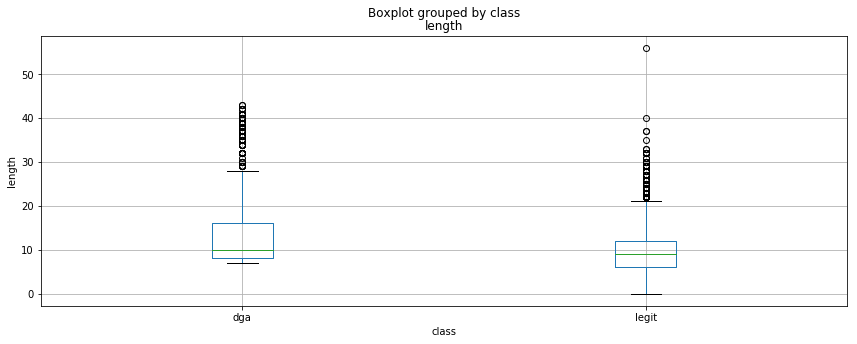

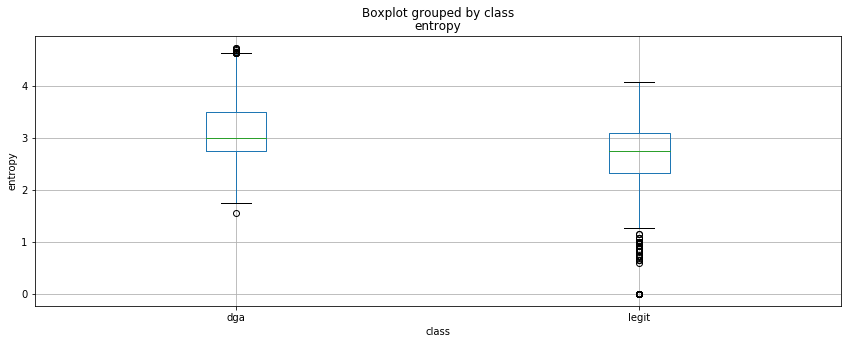

In [147]:
#通过盒图来查看整个数据分布
import matplotlib.pylab as plt
all_domains.boxplot('length','class')
plt.ylabel('length')
all_domains.boxplot('entropy','class')
plt.ylabel('entropy')
plt.show()

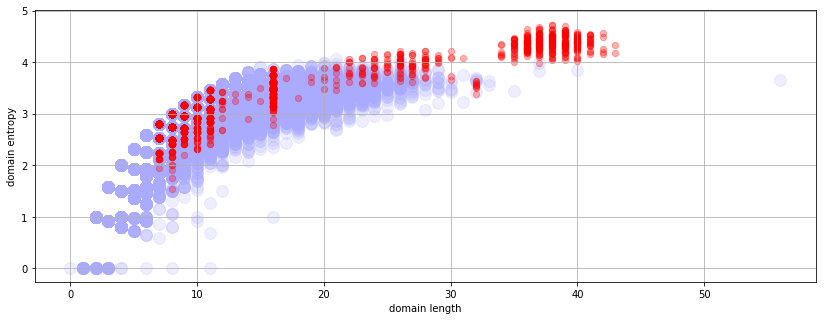

In [148]:
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
alexa = all_domains[~cond]
plt.scatter(alexa['length'],alexa['entropy'],s=140,c='#aaaaff',label='Alexa',alpha=.2)
plt.scatter(dga['length'],dga['entropy'],s=40,c='r',label='dga',alpha=.3)
plt.xlabel('domain length')
plt.ylabel('domain entropy')
plt.show()

In [149]:
#构建训练X输入矩阵
X = all_domains.as_matrix(['length','entropy'])
#构建y结果
y= np.array(all_domains['class'].tolist())

In [151]:
import sklearn.ensemble
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20)

In [155]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(clf,X,y,cv=5,n_jobs=4)
print scores
#emmmmm这个大概97.5的准确率甚是喜人啊

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[ 0.97666588  0.97654773  0.97737343  0.97619188  0.97323644]
